# STAT 345: Nonparametric Statistics

## Lesson 08.2: The Kolmogorov-Smirnov and Related Two-Sample Tests

**Reading: Conover Section 6.3**

*Prof. John T. Whelan*

Thursday 20 March 2025

These lecture slides are in a computational notebook.  You have access to them through http://vmware.rit.edu/

Flat HTML and slideshow versions are also in MyCourses.

The notebook can run Python commands (other notebooks can use R or Julia; "Ju-Pyt-R").  Think: computational data analysis, not "coding".

Standard commands to activate inline interface and import libraries:

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.rcParams['font.size'] = 14

Finally, we consider the case where we have two samples
$\{x_i|i=1,\ldots,n\}$ and $\{y_j|j=1,\ldots,m\}$, and wish to ask
whether they come from the same distribution. We’ve approached this
question as a comparison of location parameters with the
Wilcoxon-Mann-Whitney rank sum test and as a comparison of scale
parameters with the Conover squared ranks test. But if we wish to make a
general comparison, one option is to compare the empirical distributions

$$\begin{gathered}
    \hat{F}_x(x;\{x_i\}) = \frac{1}{n}\sum_{i=1}^n I[x_i{\mathbin{\le}}x]
    =
    \begin{cases}
      0 & x < x^{(1)} \\
      \frac{i}{n} & x^{(i)} \le x < x^{(i+1)} \\
      1 & x^{(n)} \le x
    \end{cases}
    \\
    \hat{F}_y(x;\{y_j\}) = \frac{1}{m}\sum_{j=1}^m I[y_j{\mathbin{\le}}x]
    =
    \begin{cases}
      0 & x < y^{(1)} \\
      \frac{j}{m} & y^{(j)} \le x < y^{(j+1)} \\
      1 & y^{(m)} \le x
    \end{cases}
  \end{gathered}$$

where $\{x^{(i)}\}$ and $\{y^{(j)}\}$ are the order statistics of the
two samples.

Consider a very simple toy data set:

In [3]:
x_i = np.array([3.14,0.1,2.72]); y_j = np.array([2,4]); n = len(x_i); m = len(y_j); N=n+m; x_i.sort(); y_j.sort();
x_i, y_j

(array([0.1 , 2.72, 3.14]), array([2, 4]))

In [4]:
Fxhat_i = (1.+np.arange(n))/n; Fyhat_j = (1.+np.arange(m))/m; X_k = np.concatenate((x_i,y_j)); X_k.sort()
print('Fxhat(x)=0 for x <= %g' % x_i[0])
for i in range(n-1):
    print('Fxhat(x)=%g for %g < x <=%g' % (Fxhat_i[i],x_i[i],x_i[i+1]))
print('Fxhat(x)=1 for %g < x' % x_i[-1]); print()
print('Fyhat(y)=0 for y <= %g' % y_j[0])
for j in range(m-1):
    print('Fyhat(y)=%g for %g < y <=%g' % (Fyhat_j[j],y_j[j],y_j[j+1]))
print('Fyhat(y)=1 for %g < y' % y_j[-1])

Fxhat(x)=0 for x <= 0.1
Fxhat(x)=0.333333 for 0.1 < x <=2.72
Fxhat(x)=0.666667 for 2.72 < x <=3.14
Fxhat(x)=1 for 3.14 < x

Fyhat(y)=0 for y <= 2
Fyhat(y)=0.5 for 2 < y <=4
Fyhat(y)=1 for 4 < y


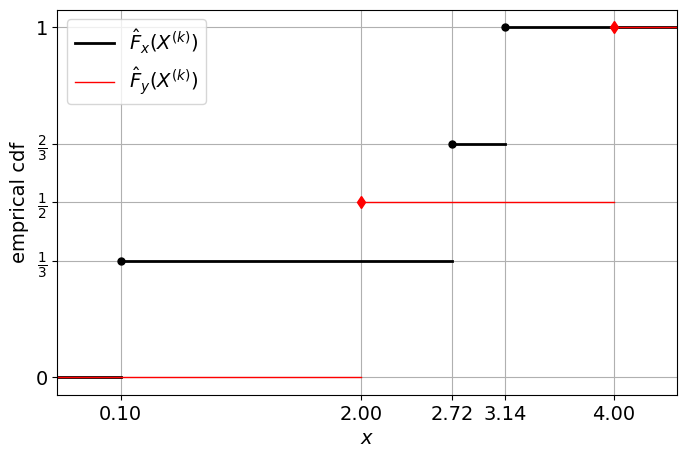

In [5]:
plt.plot(x_i,Fxhat_i,'k.',ms=10);
for i in range(n-1): plt.plot(x_i[i:i+2],[Fxhat_i[i],Fxhat_i[i]],'k-',lw=2);
plt.plot([X_k[0]-1,x_i[0]],[0,0],'k-',lw=2,label=r'$\hat{F}_x(X^{(k)})$');plt.plot([x_i[-1],X_k[-1]+1],[1,1],'k-',lw=2);
plt.plot(y_j,Fyhat_j,'rd');
for j in range(m-1): plt.plot(y_j[j:j+2],[Fyhat_j[j],Fyhat_j[j]],'r-',lw=1);
plt.plot([X_k[0]-1,y_j[0]],[0,0],'r-',lw=1,label=r'$\hat{F}_y(X^{(k)})$');plt.plot([y_j[-1],X_k[-1]+1],[1,1],'r-',lw=1);
plt.legend();plt.xlabel(r'$x$');plt.ylabel(r'emprical cdf');plt.xticks(np.unique(X_k));plt.xlim(min(X_k)-0.5,max(X_k)+0.5);plt.ylim(-0.05,1.05);plt.grid();plt.yticks([0,1./3.,1./2,2./3.,1],[r'$0$',r'$\frac{1}{3}$',r'$\frac{1}{2}$',r'$\frac{2}{3}$',r'$1$']);

## Two-Sample Kolmogorov-Smirnov

To perform a Kolmogorov-Smirnov test with the two empirical cdfs, we
define the statistics
$$\begin{gathered}
    T^{+} = \sup\left(\hat{F}_x(x)-\hat{F}_y(x)\right) \qquad\hbox{and}\qquad
    T^{-} = \sup\left(\hat{F}_y(x)-\hat{F}_x(x)\right) \\
    T = \sup{\left\lvert\hat{F}_x(x)-\hat{F}_y(x)\right\rvert} = \max(T^{+},T^{-})
  \end{gathered}$$
Look at this for our simple data:

In [6]:
Fxhat_k = np.mean(x_i[None,:] <= X_k[:,None], axis=-1); Fyhat_k = np.mean(y_j[None,:] <= X_k[:,None], axis=-1)
print('For        X <= %.2f, Fxhat(X)-Fyhat(X) = 0-0 = 0' % X_k[0])
for k in range(1,N):
    print('For %.2f < X <= %.2f, Fxhat(X)-Fyhat(X) = %g-%g = %g'
          % (X_k[k-1],X_k[k],Fxhat_k[k-1],Fyhat_k[k-1],Fxhat_k[k-1]-Fyhat_k[k-1]))
print('For %g < X           , Fxhat(X)-Fyhat(X) = 1-1 = 0' % X_k[-1])
Tp = max(Fxhat_k-Fyhat_k); Tm = max(Fyhat_k-Fxhat_k); T=max(Tp,Tm); Tp, Tm, T

For        X <= 0.10, Fxhat(X)-Fyhat(X) = 0-0 = 0
For 0.10 < X <= 2.00, Fxhat(X)-Fyhat(X) = 0.333333-0 = 0.333333
For 2.00 < X <= 2.72, Fxhat(X)-Fyhat(X) = 0.333333-0.5 = -0.166667
For 2.72 < X <= 3.14, Fxhat(X)-Fyhat(X) = 0.666667-0.5 = 0.166667
For 3.14 < X <= 4.00, Fxhat(X)-Fyhat(X) = 1-0.5 = 0.5
For 4 < X           , Fxhat(X)-Fyhat(X) = 1-1 = 0


(0.5, 0.16666666666666669, 0.5)

$T^{+}=\max_k \left(\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})\right)=\frac{1}{2}$ and $T^{-}=\max_k \left(\hat{F}_y(X^{(k)})-\hat{F}_x(X^{(k)})\right)=\frac{1}{6}$

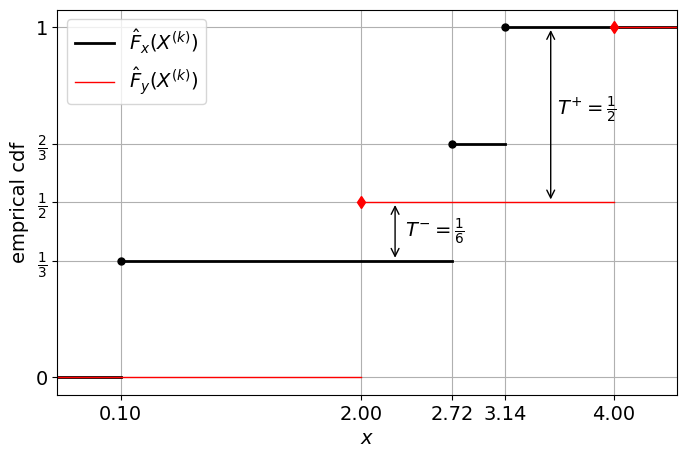

In [7]:
plt.plot(x_i,Fxhat_i,'k.',ms=10);
for i in range(n-1): plt.plot(x_i[i:i+2],[Fxhat_i[i],Fxhat_i[i]],'k-',lw=2);
plt.plot([X_k[0]-1,x_i[0]],[0,0],'k-',lw=2,label=r'$\hat{F}_x(X^{(k)})$');plt.plot([x_i[-1],X_k[-1]+1],[1,1],'k-',lw=2);
plt.plot(y_j,Fyhat_j,'rd');
for j in range(m-1): plt.plot(y_j[j:j+2],[Fyhat_j[j],Fyhat_j[j]],'r-',lw=1);
plt.plot([X_k[0]-1,y_j[0]],[0,0],'r-',lw=1,label=r'$\hat{F}_y(X^{(k)})$');plt.plot([y_j[-1],X_k[-1]+1],[1,1],'r-',lw=1);
plt.annotate('',xy=(3.5,0.5),xycoords='data',xytext=(3.5,1.),textcoords='data',arrowprops=dict(arrowstyle='<->'));plt.text(3.55,0.75,r'$T^{+}=\frac{1}{2}$');plt.annotate('',xy=(2.27,0.5),xycoords='data', xytext=(2.27,1./3.),textcoords='data',arrowprops=dict(arrowstyle='<->'));
plt.text(2.35,5./12.,r'$T^{-}=\frac{1}{6}$',va='center');
plt.legend();plt.xlabel(r'$x$');plt.ylabel(r'emprical cdf');plt.xticks(np.unique(X_k));plt.xlim(min(X_k)-0.5,max(X_k)+0.5);plt.ylim(-0.05,1.05);plt.grid();plt.yticks([0,1./3.,1./2,2./3.,1],[r'$0$',r'$\frac{1}{3}$',r'$\frac{1}{2}$',r'$\frac{2}{3}$',r'$1$']);

We see that $T^{+}=1-\frac{1}{2}=\frac{1}{2}$,
$T^{-}=\frac{1}{2}-\frac{1}{3}=\frac{1}{6}$ and thus $T=\frac{1}{2}$.

Two-sample K-S statistic doesn't actually use values of
the $\{x_i\}$ and $\{y_j\}$, just ordering, so we could also use
the ranks of the data rather than the data themselves:

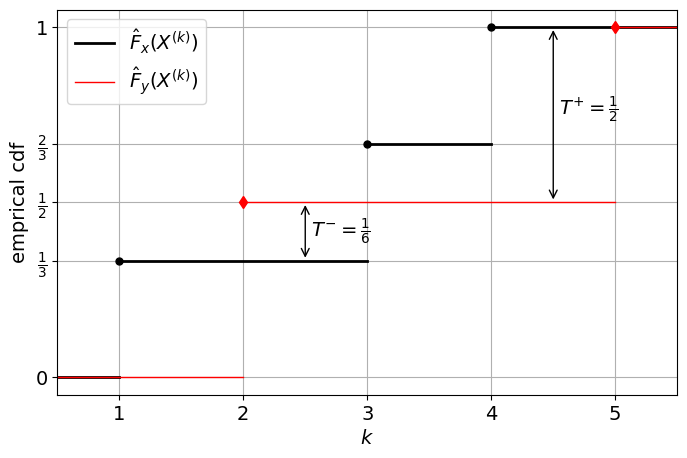

In [8]:
Rxy_k = stats.rankdata(np.concatenate((x_i,y_j))); Rx_i=Rxy_k[:n]; Ry_j=Rxy_k[n:]; RX_k = np.sort(Rxy_k)
plt.plot(Rx_i,Fxhat_i,'k.',ms=10);plt.plot([0,Rx_i[0]],[0,0],'k-',lw=2,label=r'$\hat{F}_x(X^{(k)})$');plt.plot([Rx_i[-1],N+1],[1,1],'k-',lw=2);plt.plot(Ry_j,Fyhat_j,'rd');
for i in range(n-1): plt.plot(Rx_i[i:i+2],[Fxhat_i[i],Fxhat_i[i]],'k-',lw=2);
for j in range(m-1): plt.plot(Ry_j[j:j+2],[Fyhat_j[j],Fyhat_j[j]],'r-',lw=1);
plt.plot([0,Ry_j[0]],[0,0],'r-',lw=1,label=r'$\hat{F}_y(X^{(k)})$');plt.plot([Ry_j[-1],N+1],[1,1],'r-',lw=1);
plt.annotate('',xy=(4.5,0.5),xycoords='data', xytext=(4.5,1.),textcoords='data',arrowprops=dict(arrowstyle='<->'));plt.text(4.55,0.75,r'$T^{+}=\frac{1}{2}$');plt.annotate('',xy=(2.5,0.5),xycoords='data', xytext=(2.5,1./3.),textcoords='data',arrowprops=dict(arrowstyle='<->'));plt.text(2.55,5./12.,r'$T^{-}=\frac{1}{6}$',va='center');
plt.xlabel(r'$k$');plt.ylabel(r'emprical cdf');plt.yticks([0,1./3.,1./2,2./3.,1],[r'$0$',r'$\frac{1}{3}$',r'$\frac{1}{2}$',r'$\frac{2}{3}$',r'$1$']);plt.xlim(min(RX_k)-0.5,max(RX_k)+0.5);plt.ylim(-0.05,1.05);plt.grid();plt.legend(loc='upper left');

This allows us to construct the null distribution by enumerating the
$\binom{n+m}{n}$ possible divisions of the ranks $1$ to $n+m$ into
$x$-ranks and $y$-ranks, and computing the Kolmogorov-Smirnov statistics
for each of them. In this case there are $\binom{5}{3}=10$
possibilities.
To loop through them, we can use the `itertools.combinations` function in Python:

In [9]:
import itertools;xranks_Ii = np.array([xranks_i for xranks_i in itertools.combinations(RX_k,n)]); xranks_Ii

array([[1., 2., 3.],
       [1., 2., 4.],
       [1., 2., 5.],
       [1., 3., 4.],
       [1., 3., 5.],
       [1., 4., 5.],
       [2., 3., 4.],
       [2., 3., 5.],
       [2., 4., 5.],
       [3., 4., 5.]])

Since the $y$ ranks are all of those which don't appear in $x$, you can find the $y$ rank list corresponding to each $x$ rank list as a set theory complement:

In [10]:
yranks_Ij = np.array([np.setdiff1d(RX_k,xranks_i) for xranks_i in xranks_Ii]); xranks_Ii, yranks_Ij

(array([[1., 2., 3.],
        [1., 2., 4.],
        [1., 2., 5.],
        [1., 3., 4.],
        [1., 3., 5.],
        [1., 4., 5.],
        [2., 3., 4.],
        [2., 3., 5.],
        [2., 4., 5.],
        [3., 4., 5.]]),
 array([[4., 5.],
        [3., 5.],
        [3., 4.],
        [2., 5.],
        [2., 4.],
        [2., 3.],
        [1., 5.],
        [1., 4.],
        [1., 3.],
        [1., 2.]]))

Then you can evaluate the two empirical distribution functions at each interesting point:

In [11]:
RX_k

array([1., 2., 3., 4., 5.])

In [12]:
Fxhat_Ik = np.mean(xranks_Ii[:,None,:]<=RX_k[None,:,None],axis=-1); Fxhat_Ik

array([[0.33333333, 0.66666667, 1.        , 1.        , 1.        ],
       [0.33333333, 0.66666667, 0.66666667, 1.        , 1.        ],
       [0.33333333, 0.66666667, 0.66666667, 0.66666667, 1.        ],
       [0.33333333, 0.33333333, 0.66666667, 1.        , 1.        ],
       [0.33333333, 0.33333333, 0.66666667, 0.66666667, 1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        , 1.        ],
       [0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.        , 0.33333333, 0.66666667, 1.        ]])

In [13]:
Fyhat_Ik = np.array([np.mean(yranks_j[None,:]<=RX_k[:,None], axis=-1) for yranks_j in yranks_Ij]); Fyhat_Ik

array([[0. , 0. , 0. , 0.5, 1. ],
       [0. , 0. , 0.5, 0.5, 1. ],
       [0. , 0. , 0.5, 1. , 1. ],
       [0. , 0.5, 0.5, 0.5, 1. ],
       [0. , 0.5, 0.5, 1. , 1. ],
       [0. , 0.5, 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. , 1. ],
       [0.5, 0.5, 1. , 1. , 1. ],
       [0.5, 1. , 1. , 1. , 1. ]])

In [14]:
Tp_I = np.max(Fxhat_Ik-Fyhat_Ik,axis=-1);Tm_I = np.max(Fyhat_Ik-Fxhat_Ik,axis=-1);
T_I = np.max(np.abs(Fxhat_Ik-Fyhat_Ik),axis=-1); T_I

array([1.        , 0.66666667, 0.66666667, 0.5       , 0.33333333,
       0.66666667, 0.5       , 0.5       , 0.66666667, 1.        ])

In [15]:
for I in range(len(T_I)):
    print('If Rx_i=',xranks_Ii[I],' Ry_j=',yranks_Ij[I],' T+=',Tp_I[I],' T-=',Tm_I[I],' so T=',T_I[I])

If Rx_i= [1. 2. 3.]  Ry_j= [4. 5.]  T+= 1.0  T-= 0.0  so T= 1.0
If Rx_i= [1. 2. 4.]  Ry_j= [3. 5.]  T+= 0.6666666666666666  T-= 0.0  so T= 0.6666666666666666
If Rx_i= [1. 2. 5.]  Ry_j= [3. 4.]  T+= 0.6666666666666666  T-= 0.33333333333333337  so T= 0.6666666666666666
If Rx_i= [1. 3. 4.]  Ry_j= [2. 5.]  T+= 0.5  T-= 0.16666666666666669  so T= 0.5
If Rx_i= [1. 3. 5.]  Ry_j= [2. 4.]  T+= 0.3333333333333333  T-= 0.33333333333333337  so T= 0.33333333333333337
If Rx_i= [1. 4. 5.]  Ry_j= [2. 3.]  T+= 0.3333333333333333  T-= 0.6666666666666667  so T= 0.6666666666666667
If Rx_i= [2. 3. 4.]  Ry_j= [1. 5.]  T+= 0.5  T-= 0.5  so T= 0.5
If Rx_i= [2. 3. 5.]  Ry_j= [1. 4.]  T+= 0.16666666666666663  T-= 0.5  so T= 0.5
If Rx_i= [2. 4. 5.]  Ry_j= [1. 3.]  T+= 0.0  T-= 0.6666666666666667  so T= 0.6666666666666667
If Rx_i= [3. 4. 5.]  Ry_j= [1. 2.]  T+= 0.0  T-= 1.0  so T= 1.0


We see (as does Conover) that $1$ of the $10$ combinations has
$T=\frac{1}{3}$, $3$ have $T=\frac{1}{2}$, $4$ have $T=\frac{2}{3}$, and
$2$ have $T=1$.  Actually, we should be a bit careful, since roundoff has caused there to be two different versions of $2/3$:

In [16]:
T_I[1], T_I[5], T_I[1]==T_I[5]

(0.6666666666666666, 0.6666666666666667, False)

In [17]:
np.unique(T_I)

array([0.33333333, 0.5       , 0.66666667, 0.66666667, 1.        ])

Since the statistic is constructed as a difference of $\hat{F}_x(X)$, which is a multiple of $\frac{1}{n}$ and  $\hat{F}_y(X)$, which is a multiple of $\frac{1}{m}$, all the possible values are integer multiples of $\frac{1}{mn}$, so we could round $mnT$ to the nearest integer: 

In [18]:
m*n*T_I

array([6., 4., 4., 3., 2., 4., 3., 3., 4., 6.])

In [19]:
np.unique(np.round(m*n*T_I)/(m*n))

array([0.33333333, 0.5       , 0.66666667, 1.        ])

But a more robust solution is just to round everything off to, say, 8 decimal places:

In [20]:
Tp_I = np.round(Tp_I,decimals=8); Tm_I = np.round(Tm_I,decimals=8); T_I = np.maximum(Tp_I,Tm_I); np.unique(T_I)

array([0.33333333, 0.5       , 0.66666667, 1.        ])

Returning to the $p$-value computation, we see that 9 of the 10 equally likely possibilities have a statistic value of at least our observed $T=0.1$, so $p=0.9$ for these data:

In [21]:
np.sort(T_I)

array([0.33333333, 0.5       , 0.5       , 0.5       , 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 1.        , 1.        ])

In [22]:
np.mean(T_I>=T)

0.9

Table A20 of Conover can be used to bound the $p$-value, although for this sample size it's not so useful.  It says, for $(m,n)=(2,3)$, $P(\color{royalblue}T\mathbin{>}5/6)=0.20$.  Note that $5/6$ is halfway in between the values $2/3$ and $1$.

In [23]:
np.mean(T_I>5/6)

0.2

Anyway, all this tells us about the $p$-value for $T=\frac{1}{2}$ is that $p>0.2$.

## Two-Sample Cramér-von Mises

- Recall one-sample Cramér-von Mises test: compare empirical
distribution $\hat{F}(x)$ to hypothesized distribution $F^*(x)$
using a statistic constructed from the integral $$
  \int_{-\infty}^{\infty} [\hat{F}(x)-F^{*}(x)]^2\,f^{*}(x)\,dx$$

- We’d
like to use the same method in the two-sample case to compare
$\hat{F}_x(x)$ and $\hat{F}_y(x)$, but there are a couple of challenges
related to the “measure” $f^{*}(x)\,dx=dF^*(x)$:

1. If we’re treating the two samples the same, which distribution goes in place of $F^*(x)$ in $dF^*(x)$?

2. Empirical cdf $\hat{F}(x)$ is always discrete; can't take derivative to get $\hat{F}{}'(x)=\hat{f}(x)$.

1. If we’re treating the two samples the same, which distribution goes in place of $F^*(x)$ in $dF^*(x)$?

Obvious choice: combine the data
sets $\{x_i|i=1,\ldots,n\}$ and $\{y_j|i=j,\ldots,m\}$ into
$\{X_k|k=1,\ldots,n+m\}$, and use this combined sample to produce an
empirical distribution function $$
    \hat{F}_{x,y}(x;\{X_k\})
    =\frac{1}{n+m}
    \left(
      \sum_{i=1}^n I[x_i{\mathbin{\le}}x]
      +\sum_{j=1}^m I[y_j{\mathbin{\le}}x]
    \right)=
    \begin{cases}
      0 & x < X^{(1)} \\
      \frac{k}{n+m} & X^{(k)} \le x < X^{(k+1)} \\
      1 & X^{(n+m)} \le x
    \end{cases}$$

and then use the definition
$$\int_{-\infty}^{\infty} [\hat{F}_x(x)-\hat{F}_y(x)]^2\,\hat{f}_{x,y}(x)\,dx$$

$$\int_{-\infty}^{\infty} [\hat{F}_x(x)-\hat{F}_y(x)]^2\,\hat{f}_{x,y}(x)\,dx$$

2. Empirical cdf $\hat{F}(x)$ is always discrete; can't take derivative<span id="fm1">[<sup>1</sup>](#fn1) to get $\hat{F}_{x,y}{}'(x)=\hat{f}_{x,y}(x)$.

<span id="fn1">[<sup>1</sup>](#fm1) Actually, we could carry out a construction based on the Dirac
    delta function, but that would involve introducing additional
    mathematical apparatus and possibly induce indigestion in
    mathematical purists.</span>

Instead, consider the integral to be an expectation value constructed using the
empirical distribution $\hat{F}_{x,y}$, which is basically a discrete distribution whose pmf is non-zero at the
values in the combined sample: $\hat{p}_{x,y}(X^{(k)})=\frac{1}{n+m}$
(assuming there are no repeated values in the combined sample).

So we
can replace the integral
$\int_{-\infty}^{\infty}(\cdots) \hat{f}_{x,y}(x)dx$ with the sum
$\sum_x (\cdots)p_{x,y}(x)$ and write a statistic based on a discrete
expectation value: $$E_{\hat{F}_{x,y}}([\hat{F}_x(\color{royalblue}{X})-\hat{F}_y(\color{royalblue}{X})]^2)
  = \sum_{k=1}^{n+m} \frac{[\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})]^2}{n+m}$$

If we construct this sum explicitly for the data set considered above,
we get $$\begin{gathered}
  \frac{1}{5}\left[
    \left(\frac{1}{3}-0\right)^2
    +\left(\frac{1}{3}-\frac{1}{2}\right)^2
    +\left(\frac{2}{3}-\frac{1}{2}\right)^2
    +\left(1-\frac{1}{2}\right)^2
    +\left(1-1\right)^2
  \right]
  \\=\frac{1}{5}\left[
    \frac{1}{9} + \frac{1}{36}
    +\frac{1}{36} + \frac{1}{4}
  \right]
  =\frac{4+1+1+9}{180} = \frac{15}{180} = \frac{1}{12}\end{gathered}$$

In [24]:
Fxhat_k, Fyhat_k, np.sum((Fxhat_k-Fyhat_k)**2)/(n+m), 1/12

(array([0.33333333, 0.33333333, 0.66666667, 1.        , 1.        ]),
 array([0. , 0.5, 0.5, 0.5, 1. ]),
 0.08333333333333333,
 0.08333333333333333)

Note that the last term is zero, which will always be true, since $\hat{F}_x(X^{(n+m)})=1=\hat{F}_y(X^{(n+m)})$ so we can leave that term out of the
sum,<span id="fm2">[<sup>2</sup>](#fn2)</span> and write the two-sample Cramér-von Mises statistic (putting an
extra $\frac{nm}{n+m}$ out front for convention) as
$$T_2 = \frac{nm}{(n+m)^2}
  \sum_{k=1}^{n+m-1} [\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})]^2$$

For the
data set in question,
$$T_2 =  \frac{nm}{(n+m)^2}
  \sum_{k=1}^{n+m-1} [\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})]^2=\frac{3\times 2}{5}\frac{1}{12} = \frac{1}{10}$$

<span id="fn2">[<sup>2</sup>](#fm2)  This clears up an apparent asymmetry where the statistic is defined by contributions from points where one of the empirical cdfs
    is discontinuous, and always uses the value to the right of the jump
    (since the cdf is by definition right-continuous). The fact that the
    contribution from the value after the last jump is zero makes up for
    the lack of a contribution from the value before the first jump.</span>

In [25]:
TCvM = n*m/N**2 * np.sum((Fxhat_k-Fyhat_k)**2); TCvM

0.09999999999999999

We can construct the $p$-value by making an array of possible statistic values, and see that actually 9 out of 10 possible arrangements of ranks have a Cramér-von Mises statistic of $0.1$ or higher.

In [26]:
TCvM_I = n*m/N**2 * np.sum((Fxhat_Ik-Fyhat_Ik)**2,axis=-1); TCvM_I

array([0.43333333, 0.2       , 0.16666667, 0.1       , 0.06666667,
       0.16666667, 0.13333333, 0.1       , 0.2       , 0.43333333])

Note that actually floating point roundoff is a danger here, since in fact one of the two $0.1$ values in the ensemble, which should all have equalled the observed value, turned out to be computed as slightly higher:

In [27]:
TCvM_I - TCvM

array([ 3.33333333e-01,  1.00000000e-01,  6.66666667e-02,  0.00000000e+00,
       -3.33333333e-02,  6.66666667e-02,  3.33333333e-02,  2.77555756e-17,
        1.00000000e-01,  3.33333333e-01])

Could note that all $T_{\text{CvM}}$ values have common denominator $(n+m)^2n^2m^2$, but easier just to round off.

In [28]:
TCvM_I = np.round(TCvM_I,8); TCvM = np.round(TCvM,8); TCvM_I, TCvM

(array([0.43333333, 0.2       , 0.16666667, 0.1       , 0.06666667,
        0.16666667, 0.13333333, 0.1       , 0.2       , 0.43333333]),
 0.1)

In [29]:
TCvM_I - TCvM

array([ 0.33333333,  0.1       ,  0.06666667,  0.        , -0.03333333,
        0.06666667,  0.03333333,  0.        ,  0.1       ,  0.33333333])

In [30]:
np.mean(TCvM_I >= TCvM)

0.9

## Two-Sample Anderson-Darling

Having laid the groundwork with the Cramér-von Mises statistic, it’s
straightforward to convert this to an Anderson-Darling statistic, by
including $\hat{F}_{xy}(x)[1-\hat{F}_{xy}(x)]$ in the denominator.
Conceptually, this normalizes the squared deviation by the expected
variance; practically, it increases the importance of outliers. The
statistic is then $$\begin{split}
    A^2 = \frac{nm}{(n+m)^2}
    \sum_{k=1}^{n+m-1}
    \frac{[\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})]^2}
    {\hat{F}_{xy}(X^{(k)})[1-\hat{F}_{xy}(X^{(k)})]}
=nm
    \sum_{k=1}^{n+m-1}
    \frac{[\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})]^2}
    {k(n+m-k)}
  \end{split}$$ Note that dropping the $k=n+m$ term from the sum has
avoided giving us a $0/0$ contribution.

To compute $A^2=nm
    \sum_{k=1}^{n+m-1}
    \frac{[\hat{F}_x(X^{(k)})-\hat{F}_y(X^{(k)})]^2}
    {k(n+m-k)}$ in Python, we define an array representing the index $k$:

In [31]:
k_k = 1 + np.arange(N); k_k, N-k_k

(array([1, 2, 3, 4, 5]), array([4, 3, 2, 1, 0]))

Note that the denominator is equal to zero for $k=N$ as noted above, but the numerator is as well

In [32]:
k_k*(N-k_k), (Fxhat_k-Fyhat_k)**2

(array([4, 6, 6, 4, 0]),
 array([0.11111111, 0.02777778, 0.02777778, 0.25      , 0.        ]))

In [33]:
(Fxhat_k-Fyhat_k)**2/(k_k*(N-k_k))

/tmp/ipykernel_682141/749764076.py:1: RuntimeWarning: invalid value encountered in divide
  (Fxhat_k-Fyhat_k)**2/(k_k*(N-k_k))


array([0.02777778, 0.00462963, 0.00462963, 0.0625    ,        nan])

We can avoid the $0/0$ term (which is explicitly excluded from the sum in the definition) by dropping the last element from all of the `_k` arrays, either when we define them in the first place, or when we use them:

In [34]:
(Fxhat_k-Fyhat_k)**2/(k_k*(N-k_k))

/tmp/ipykernel_682141/749764076.py:1: RuntimeWarning: invalid value encountered in divide
  (Fxhat_k-Fyhat_k)**2/(k_k*(N-k_k))


array([0.02777778, 0.00462963, 0.00462963, 0.0625    ,        nan])

In [35]:
(Fxhat_k[:-1]-Fyhat_k[:-1])**2/(k_k[:-1]*(N-k_k[:-1]))

array([0.02777778, 0.00462963, 0.00462963, 0.0625    ])

In [36]:
A2 = n*m*np.sum( (Fxhat_k[:-1]-Fyhat_k[:-1])**2 / (k_k[:-1]*(N-k_k[:-1])) ); A2

0.5972222222222222

Obviously, the two-sample Anderson-Darling statistic can be constructed from the ranks as well, so the associated $p$-value can be calculated as was done for the the Kolmogorov-Smirnov and Cramér-von Mises tests above.  Note that both Cramér-von Mises and Anderson-Darling are implicitly one-tailed, though, since the deviation has been squared.

In [37]:
A2_I = n*m*np.sum( (Fxhat_Ik[:,:-1]-Fyhat_Ik[:,:-1])**2 / (k_k[None,:-1]*(N-k_k[None,:-1])), axis=-1 ); A2_I

array([1.98611111, 1.01388889, 0.80555556, 0.59722222, 0.38888889,
       0.80555556, 0.80555556, 0.59722222, 1.01388889, 1.98611111])

In [38]:
A2 = np.round(A2,8); A2_I = np.round(A2_I,8); np.mean(A2_I>=A2)

0.9

Note that while each of the three tests gives a $p$-value of $0.9$ for this toy data set, they perform differently on generic data.

## Dealing with Ties

Things get a bit complicated if there are any tied data points (which is only possible if the data are discrete):

In [39]:
x_i = np.array([3,0,2.5,2]); y_j = np.array([2,4,4]); n = len(x_i); m = len(y_j); N=n+m; x_i.sort(); y_j.sort();
x_i, y_j

(array([0. , 2. , 2.5, 3. ]), array([2, 4, 4]))

In [40]:
Fxhat_i = (1.+np.arange(n))/n; Fyhat_j = (1.+np.arange(m))/m; X_k = np.concatenate((x_i,y_j)); X_k.sort()
print('Fxhat(x)=0 for x < %g' % x_i[0])
for i in range(n-1):
    print('Fxhat(x)=%g for %g <= x <%g' % (Fxhat_i[i],x_i[i],x_i[i+1]))
print('Fxhat(x)=1 for %g <= x' % x_i[-1]); print()
print('Fyhat(y)=0 for y < %g' % y_j[0])
for j in range(m-1):
    print('Fyhat(y)=%g for %g <= y <%g' % (Fyhat_j[j],y_j[j],y_j[j+1]))
print('Fyhat(y)=1 for %g <= y' % y_j[-1])

Fxhat(x)=0 for x < 0
Fxhat(x)=0.25 for 0 <= x <2
Fxhat(x)=0.5 for 2 <= x <2.5
Fxhat(x)=0.75 for 2.5 <= x <3
Fxhat(x)=1 for 3 <= x

Fyhat(y)=0 for y < 2
Fyhat(y)=0.333333 for 2 <= y <4
Fyhat(y)=0.666667 for 4 <= y <4
Fyhat(y)=1 for 4 <= y


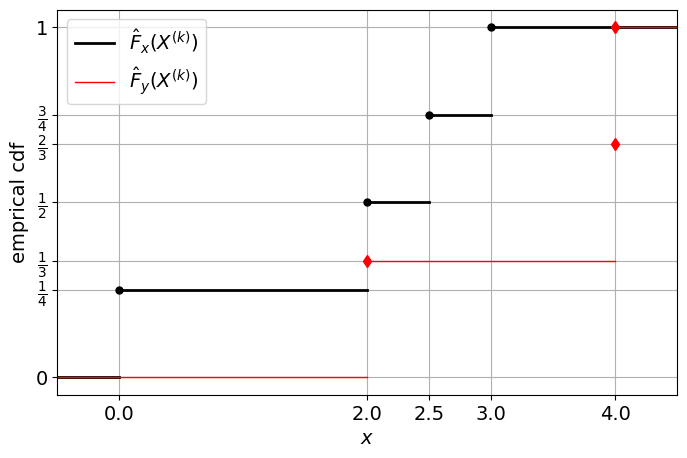

In [41]:
plt.plot(x_i,Fxhat_i,'k.',ms=10);
for i in range(n-1): plt.plot(x_i[i:i+2],[Fxhat_i[i],Fxhat_i[i]],'k-',lw=2);
plt.plot([X_k[0]-1,x_i[0]],[0,0],'k-',lw=2,label=r'$\hat{F}_x(X^{(k)})$');plt.plot([x_i[-1],X_k[-1]+1],[1,1],'k-',lw=2);
plt.plot(y_j,Fyhat_j,'rd');
for j in range(m-1): plt.plot(y_j[j:j+2],[Fyhat_j[j],Fyhat_j[j]],'r-',lw=1);
plt.plot([X_k[0]-1,y_j[0]],[0,0],'r-',lw=1,label=r'$\hat{F}_y(X^{(k)})$');plt.plot([y_j[-1],X_k[-1]+1],[1,1],'r-',lw=1);
plt.legend();plt.xlabel(r'$x$');plt.ylabel(r'emprical cdf');plt.xticks(np.unique(X_k));plt.xlim(min(X_k)-0.5,max(X_k)+0.5);plt.ylim(-0.05,1.05);plt.grid();plt.yticks([0,1./4.,1./3.,1./2,2./3.,3./4.,1],[r'$0$',r'$\frac{1}{4}$',r'$\frac{1}{3}$',r'$\frac{1}{2}$',r'$\frac{2}{3}$',r'$\frac{3}{4}$',r'$1$']);

In [42]:
k_k = 1 + np.arange(N); k_k, N-k_k

(array([1, 2, 3, 4, 5, 6, 7]), array([6, 5, 4, 3, 2, 1, 0]))

In [43]:
Fxhat_k = np.mean(x_i[None,:] <= X_k[:,None], axis=-1); Fyhat_k = np.mean(y_j[None,:] <= X_k[:,None], axis=-1)
print('For        X <= %.2f, Fxhat(X)-Fyhat(X) = 0-0 = 0' % X_k[0])
for k in range(1,N):
    print('For %.2f < X <= %.2f, Fxhat(X)-Fyhat(X) = %g-%g = %g, Fxyhat(X)=%g'
          % (X_k[k-1],X_k[k],Fxhat_k[k-1],Fyhat_k[k-1],Fxhat_k[k-1]-Fyhat_k[k-1],k_k[k-1]/N))
print('For %g < X           , Fxhat(X)-Fyhat(X) = 1-1 = 0' % X_k[-1])
Tp = max(Fxhat_k-Fyhat_k); Tm = max(Fyhat_k-Fxhat_k); T=max(Tp,Tm); Tp, Tm, T

For        X <= 0.00, Fxhat(X)-Fyhat(X) = 0-0 = 0
For 0.00 < X <= 2.00, Fxhat(X)-Fyhat(X) = 0.25-0 = 0.25, Fxyhat(X)=0.142857
For 2.00 < X <= 2.00, Fxhat(X)-Fyhat(X) = 0.5-0.333333 = 0.166667, Fxyhat(X)=0.285714
For 2.00 < X <= 2.50, Fxhat(X)-Fyhat(X) = 0.5-0.333333 = 0.166667, Fxyhat(X)=0.428571
For 2.50 < X <= 3.00, Fxhat(X)-Fyhat(X) = 0.75-0.333333 = 0.416667, Fxyhat(X)=0.571429
For 3.00 < X <= 4.00, Fxhat(X)-Fyhat(X) = 1-0.333333 = 0.666667, Fxyhat(X)=0.714286
For 4.00 < X <= 4.00, Fxhat(X)-Fyhat(X) = 1-1 = 0, Fxyhat(X)=0.857143
For 4 < X           , Fxhat(X)-Fyhat(X) = 1-1 = 0


(0.6666666666666667, 0.0, 0.6666666666666667)

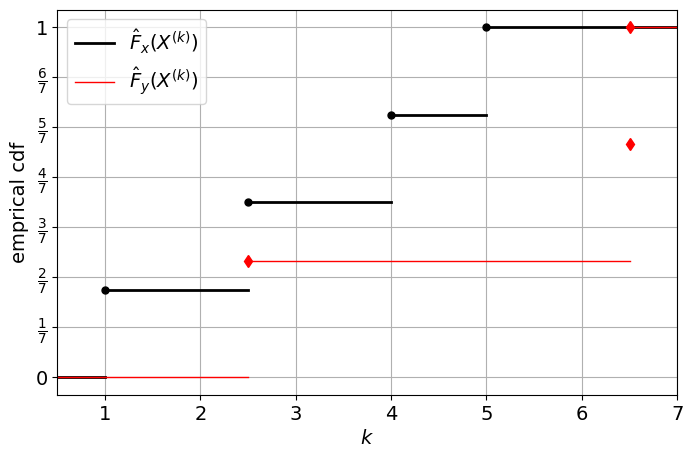

In [44]:
Rxy_k = stats.rankdata(np.concatenate((x_i,y_j))); Rx_i=Rxy_k[:n]; Ry_j=Rxy_k[n:]; RX_k = np.sort(Rxy_k)
plt.plot(Rx_i,Fxhat_i,'k.',ms=10);plt.plot([0,Rx_i[0]],[0,0],'k-',lw=2,label=r'$\hat{F}_x(X^{(k)})$');plt.plot([Rx_i[-1],N+1],[1,1],'k-',lw=2);plt.plot(Ry_j,Fyhat_j,'rd');
for i in range(n-1): plt.plot(Rx_i[i:i+2],[Fxhat_i[i],Fxhat_i[i]],'k-',lw=2);
for j in range(m-1): plt.plot(Ry_j[j:j+2],[Fyhat_j[j],Fyhat_j[j]],'r-',lw=1);
plt.plot([0,Ry_j[0]],[0,0],'r-',lw=1,label=r'$\hat{F}_y(X^{(k)})$');plt.plot([Ry_j[-1],N+1],[1,1],'r-',lw=1);
plt.xlabel(r'$k$');plt.ylabel(r'emprical cdf');plt.yticks(np.arange(N+1)/N,[r'$0$',r'$\frac{1}{7}$',r'$\frac{2}{7}$',r'$\frac{3}{7}$',r'$\frac{4}{7}$',r'$\frac{5}{7}$',r'$\frac{6}{7}$',r'$1$']);plt.xlim(min(RX_k)-0.5,max(RX_k)+0.5);plt.ylim(-0.05,1.05);plt.grid();plt.legend(loc='upper left');

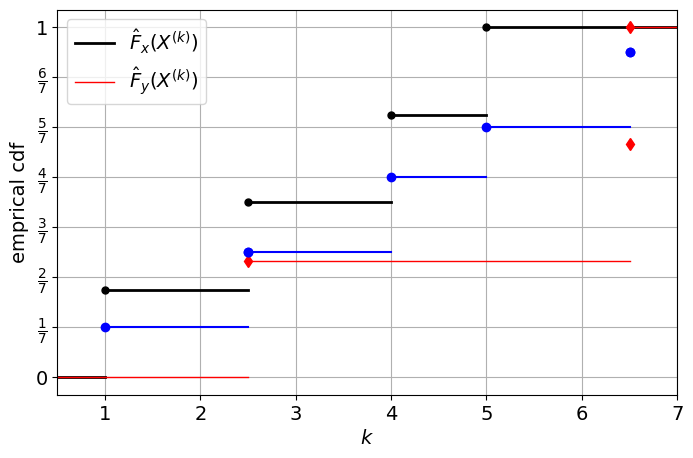

In [45]:
Rxy_k = stats.rankdata(np.concatenate((x_i,y_j))); Rx_i=Rxy_k[:n]; Ry_j=Rxy_k[n:]; RX_k = np.sort(Rxy_k)
k_k = np.arange(1,N+1); Fmid_k = RX_k/N
plt.plot(Rx_i,Fxhat_i,'k.',ms=10);plt.plot([0,Rx_i[0]],[0,0],'k-',lw=2,label=r'$\hat{F}_x(X^{(k)})$');plt.plot([Rx_i[-1],N+1],[1,1],'k-',lw=2);plt.plot(Ry_j,Fyhat_j,'rd');
for i in range(n-1): plt.plot(Rx_i[i:i+2],[Fxhat_i[i],Fxhat_i[i]],'k-',lw=2);
for j in range(m-1): plt.plot(Ry_j[j:j+2],[Fyhat_j[j],Fyhat_j[j]],'r-',lw=1);
plt.plot([0,Ry_j[0]],[0,0],'r-',lw=1,label=r'$\hat{F}_y(X^{(k)})$');plt.plot([Ry_j[-1],N+1],[1,1],'r-',lw=1);
plt.plot(RX_k,Fmid_k,'bo');
for k in range(N-1): plt.plot(RX_k[k:k+2],[Fmid_k[k],Fmid_k[k]],'b-');
plt.xlabel(r'$k$');plt.ylabel(r'emprical cdf');plt.yticks(np.arange(N+1)/N,[r'$0$',r'$\frac{1}{7}$',r'$\frac{2}{7}$',r'$\frac{3}{7}$',r'$\frac{4}{7}$',r'$\frac{5}{7}$',r'$\frac{6}{7}$',r'$1$']);plt.xlim(min(RX_k)-0.5,max(RX_k)+0.5);plt.ylim(-0.05,1.05);plt.grid();plt.legend(loc='upper left');